In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb

In [ ]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2_spei1 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2_spei1

## Data Preprocessing

In [ ]:
# function to create dataset
def create_dataset(pet_df, precip_df, temp_df, maxTemp_df, minTemp_df, spei_df, timescale):
  pet_df = pet_df.drop(columns=['lat', 'lon'], axis=1)
  precip_df = precip_df.drop(columns=['lat', 'lon'], axis=1)
  temp_df = temp_df.drop(columns=['lat', 'lon'], axis=1)
  maxTemp_df = maxTemp_df.drop(columns=['lat', 'lon'], axis=1)
  minTemp_df = minTemp_df.drop(columns=['lat', 'lon'], axis=1)
  spei_df = spei_df.drop(columns=['lat', 'lon'], axis=1)

  spei_label = f"spei-{timescale}"
  spei_df.rename(columns={'spei': spei_label}, inplace=True)

  pet_df['time'] = pd.to_datetime(pet_df['time'])
  precip_df['time'] = pd.to_datetime(precip_df['time'])
  temp_df['time'] = pd.to_datetime(temp_df['time'])
  maxTemp_df['time'] = pd.to_datetime(maxTemp_df['time'])
  minTemp_df['time'] = pd.to_datetime(minTemp_df['time'])
  spei_df['time'] = pd.to_datetime(spei_df['time'])

  # merge dataframes
  merged_df = pd.merge(pet_df, precip_df, on='time', how='outer')
  merged_df = pd.merge(merged_df, temp_df, on='time', how='outer')
  merged_df = pd.merge(merged_df, maxTemp_df, on='time', how='outer')
  merged_df = pd.merge(merged_df, minTemp_df, on='time', how='outer')
  merged_df = pd.merge(merged_df, spei_df, on='time', how='outer')

  return merged_df


In [ ]:
# turn time series dataset into supervised learning dataset
def create_lag_features(df, feature_columns, target_column, lags):
  df = df.copy()

  for col in feature_columns + [target_column]:  # lag both climate variables and SPEI
    for lag in range(1, lags + 1):
      df[f"{col}_lag{lag}"] = df[col].shift(lag)

  df = df.dropna()
  return df

### SPEI-1

In [ ]:
# 1950-2023 data

pet_df = pd.read_csv("/content/Monthly_PET_1950_2023_Fresno.csv")
precip_df = pd.read_csv("/content/Monthly_Precip_1950_2023_Fresno.csv")
temp_df = pd.read_csv("/content/Monthly_Temp_1950_2023_Fresno.csv")
maxTemp_df = pd.read_csv("/content/Monthly_MaxTemp_1950_2023_Fresno.csv")
minTemp_df = pd.read_csv("/content/Monthly_MinTemp_1950_2023_Fresno.csv")

# load spei data
spei_df = pd.read_csv("/content/SPEI_1_MonthTimescale_1950_2023_Fresno.csv")
timescale = 1

dataset_df_1950_2023_spei1 = create_dataset(pet_df, precip_df, temp_df, maxTemp_df, minTemp_df, spei_df, timescale)
print(f"length of dataset = {len(dataset_df_1950_2023_spei1)}")
dataset_df_1950_2023_spei1.head()

length of dataset = 888


,time,pet,pre,tmp,tmx,tmn,spei-1
0,1950-01-16,1.1,69.9,6.100000,11.100000,1.2,0.568691
1,1950-02-15,1.9,36.5,10.500000,17.300001,3.8,-0.323044
2,1950-03-16,2.7,34.0,11.900001,19.400000,4.5,-0.148050
3,1950-04-16,4.8,19.5,17.200000,25.800001,8.6,-0.585959
4,1950-05-16,6.5,3.0,20.200000,29.400000,11.1,-0.860067


In [ ]:
# create lagged data
climate_cols = ["pet", "pre", "tmp", "tmx", "tmn"]
target_col = "spei-1"
lags = 0
lagged_spei1_1950_2023 = create_lag_features(dataset_df_1950_2023_spei1, climate_cols, target_col, lags)

lagged_spei1_1950_2023.head()

,time,pet,pre,tmp,tmx,tmn,spei-1
0,1950-01-16,1.1,69.9,6.100000,11.100000,1.2,0.568691
1,1950-02-15,1.9,36.5,10.500000,17.300001,3.8,-0.323044
2,1950-03-16,2.7,34.0,11.900001,19.400000,4.5,-0.148050
3,1950-04-16,4.8,19.5,17.200000,25.800001,8.6,-0.585959
4,1950-05-16,6.5,3.0,20.200000,29.400000,11.1,-0.860067


In [ ]:
lagged_spei1_1950_2023.columns

Index(['time', 'pet', 'pre', 'tmp', 'tmx', 'tmn', 'spei-1'], dtype='object')

In [ ]:
# data splits

# -------- 80/20 train/test -------- #
# train_size = int(len(lagged_spei6_1950_2023) * 0.8)

# train_spei6 = lagged_spei6_1950_2023[:train_size]
# test_spei6 = lagged_spei6_1950_2023[train_size:]

# X_train_spei6, y_train_spei6 = train_spei6.drop(columns=["time", "spei-6"]), train_spei6["spei-6"]
# X_test_spei6, y_test_spei6 = test_spei6.drop(columns=["time", "spei-6"]), test_spei6["spei-6"]

# print(f"Training splits (80%):  X_train = {X_train_spei6.shape} | y_train = {y_train_spei6.shape}")
# print(f"Test splits (20%):  X_test = {X_test_spei6.shape} | y_test = {y_test_spei6.shape}")

# -------- 80/10/10 train/val/test -------- #
train_size = int(len(lagged_spei1_1950_2023) * 0.8)
val_size = int(len(lagged_spei1_1950_2023) * 0.1)

train_spei1 = lagged_spei1_1950_2023.iloc[:train_size]
val_spei1 = lagged_spei1_1950_2023.iloc[train_size : train_size + val_size]
test_spei1 = lagged_spei1_1950_2023.iloc[train_size + val_size :]

# Define features and target
X_train_spei1, y_train_spei1 = train_spei1.drop(columns=["time", "spei-1"]), train_spei1["spei-1"]
X_val_spei1, y_val_spei1 = val_spei1.drop(columns=["time", "spei-1"]), val_spei1["spei-1"]
X_test_spei1, y_test_spei1 = test_spei1.drop(columns=["time", "spei-1"]), test_spei1["spei-1"]

# Print dataset sizes
print(f"Training splits (80%):  X_train = {X_train_spei1.shape}, y_train = {y_train_spei1.shape}")
print(f"Validation splits (10%):  X_val = {X_val_spei1.shape}, y_val = {y_val_spei1.shape}")
print(f"Test splits (10%):  X_test = {X_test_spei1.shape}, y_test = {y_test_spei1.shape}")

Training splits (80%):  X_train = (710, 5), y_train = (710,)
Validation splits (10%):  X_val = (88, 5), y_val = (88,)
Test splits (10%):  X_test = (90, 5), y_test = (90,)


In [ ]:
print(X_train_spei1.iloc[0])
print(y_train_spei1.iloc[0])

pet     1.1
pre    69.9
tmp     6.1
tmx    11.1
tmn     1.2
Name: 0, dtype: float64
0.56869113


### SPEI-3

In [ ]:
# 1950-2023 data

pet_df = pd.read_csv("/content/Monthly_PET_1950_2023_Fresno.csv")
precip_df = pd.read_csv("/content/Monthly_Precip_1950_2023_Fresno.csv")
temp_df = pd.read_csv("/content/Monthly_Temp_1950_2023_Fresno.csv")
maxTemp_df = pd.read_csv("/content/Monthly_MaxTemp_1950_2023_Fresno.csv")
minTemp_df = pd.read_csv("/content/Monthly_MinTemp_1950_2023_Fresno.csv")

# load spei data
spei_df = pd.read_csv("/content/SPEI_3_MonthTimescale_1950_2023_Fresno.csv")
timescale = 3

dataset_df_1950_2023_spei3 = create_dataset(pet_df, precip_df, temp_df, maxTemp_df, minTemp_df, spei_df, timescale)
print(f"length of dataset = {len(dataset_df_1950_2023_spei3)}")
dataset_df_1950_2023_spei3.head()

length of dataset = 888


,time,pet,pre,tmp,tmx,tmn,spei-3
0,1950-01-16,1.1,69.9,6.100000,11.100000,1.2,-0.113825
1,1950-02-15,1.9,36.5,10.500000,17.300001,3.8,-0.082312
2,1950-03-16,2.7,34.0,11.900001,19.400000,4.5,-0.025755
3,1950-04-16,4.8,19.5,17.200000,25.800001,8.6,-0.624708
4,1950-05-16,6.5,3.0,20.200000,29.400000,11.1,-0.823265


In [ ]:
# create lagged data
climate_cols = ["pet", "pre", "tmp", "tmx", "tmn"]
target_col = "spei-3"
lags = 2
lagged_spei3_1950_2023 = create_lag_features(dataset_df_1950_2023_spei3, climate_cols, target_col, lags)

lagged_spei3_1950_2023.head()

,time,pet,pre,tmp,tmx,tmn,spei-3,pet_lag1,pet_lag2,pre_lag1,pre_lag2,tmp_lag1,tmp_lag2,tmx_lag1,tmx_lag2,tmn_lag1,tmn_lag2,spei-3_lag1,spei-3_lag2
2,1950-03-16,2.700000,34.0,11.900001,19.400000,4.500000,-0.025755,1.9,1.1,36.5,69.9,10.500000,6.100000,17.300001,11.100000,3.800000,1.2,-0.082312,-0.113825
3,1950-04-16,4.800000,19.5,17.200000,25.800001,8.600000,-0.624708,2.7,1.9,34.0,36.5,11.900001,10.500000,19.400000,17.300001,4.500000,3.8,-0.025755,-0.082312
4,1950-05-16,6.500000,3.0,20.200000,29.400000,11.100000,-0.823265,4.8,2.7,19.5,34.0,17.200000,11.900001,25.800001,19.400000,8.600000,4.5,-0.624708,-0.025755
5,1950-06-16,7.400000,0.0,22.900000,32.500000,13.400001,-0.667651,6.5,4.8,3.0,19.5,20.200000,17.200000,29.400000,25.800001,11.100000,8.6,-0.823265,-0.624708
6,1950-07-16,8.400001,2.0,28.000000,37.900000,18.200000,-0.542390,7.4,6.5,0.0,3.0,22.900000,20.200000,32.500000,29.400000,13.400001,11.1,-0.667651,-0.823265


In [ ]:
lagged_spei3_1950_2023.columns

Index(['time', 'pet', 'pre', 'tmp', 'tmx', 'tmn', 'spei-3', 'pet_lag1',
       'pet_lag2', 'pre_lag1', 'pre_lag2', 'tmp_lag1', 'tmp_lag2', 'tmx_lag1',
       'tmx_lag2', 'tmn_lag1', 'tmn_lag2', 'spei-3_lag1', 'spei-3_lag2'],
      dtype='object')

In [ ]:
# data splits

# -------- 80/20 train/test -------- #
# train_size = int(len(lagged_spei6_1950_2023) * 0.8)

# train_spei6 = lagged_spei6_1950_2023[:train_size]
# test_spei6 = lagged_spei6_1950_2023[train_size:]

# X_train_spei6, y_train_spei6 = train_spei6.drop(columns=["time", "spei-6"]), train_spei6["spei-6"]
# X_test_spei6, y_test_spei6 = test_spei6.drop(columns=["time", "spei-6"]), test_spei6["spei-6"]

# print(f"Training splits (80%):  X_train = {X_train_spei6.shape} | y_train = {y_train_spei6.shape}")
# print(f"Test splits (20%):  X_test = {X_test_spei6.shape} | y_test = {y_test_spei6.shape}")

# -------- 80/10/10 train/val/test -------- #
train_size = int(len(lagged_spei3_1950_2023) * 0.8)
val_size = int(len(lagged_spei3_1950_2023) * 0.1)

train_spei3 = lagged_spei3_1950_2023.iloc[:train_size]
val_spei3 = lagged_spei3_1950_2023.iloc[train_size : train_size + val_size]
test_spei3 = lagged_spei3_1950_2023.iloc[train_size + val_size :]

# Define features and target
X_train_spei3, y_train_spei3 = train_spei3.drop(columns=["time", "spei-3"]), train_spei3["spei-3"]
X_val_spei3, y_val_spei3 = val_spei3.drop(columns=["time", "spei-3"]), val_spei3["spei-3"]
X_test_spei3, y_test_spei3 = test_spei3.drop(columns=["time", "spei-3"]), test_spei3["spei-3"]

# Print dataset sizes
print(f"Training splits (80%):  X_train = {X_train_spei3.shape}, y_train = {y_train_spei3.shape}")
print(f"Validation splits (10%):  X_val = {X_val_spei3.shape}, y_val = {y_val_spei3.shape}")
print(f"Test splits (10%):  X_test = {X_test_spei3.shape}, y_test = {y_test_spei3.shape}")

Training splits (80%):  X_train = (708, 17), y_train = (708,)
Validation splits (10%):  X_val = (88, 17), y_val = (88,)
Test splits (10%):  X_test = (90, 17), y_test = (90,)


In [ ]:
print(X_train_spei3.iloc[0])
print(y_train_spei3.iloc[0])

pet             2.700000
pre            34.000000
tmp            11.900001
tmx            19.400000
tmn             4.500000
pet_lag1        1.900000
pet_lag2        1.100000
pre_lag1       36.500000
pre_lag2       69.900000
tmp_lag1       10.500000
tmp_lag2        6.100000
tmx_lag1       17.300001
tmx_lag2       11.100000
tmn_lag1        3.800000
tmn_lag2        1.200000
spei-3_lag1    -0.082312
spei-3_lag2    -0.113825
Name: 2, dtype: float64
-0.025755377


### SPEI-6

In [ ]:
# 1950-2023 data

pet_df = pd.read_csv("/content/Monthly_PET_1950_2023_Fresno.csv")
precip_df = pd.read_csv("/content/Monthly_Precip_1950_2023_Fresno.csv")
temp_df = pd.read_csv("/content/Monthly_Temp_1950_2023_Fresno.csv")
maxTemp_df = pd.read_csv("/content/Monthly_MaxTemp_1950_2023_Fresno.csv")
minTemp_df = pd.read_csv("/content/Monthly_MinTemp_1950_2023_Fresno.csv")

# load spei data
spei_df = pd.read_csv("/content/SPEI_6_MonthTimescale_1950_2023_Fresno.csv")
timescale = 6

dataset_df_1950_2023_spei6 = create_dataset(pet_df, precip_df, temp_df, maxTemp_df, minTemp_df, spei_df, timescale)
print(f"length of dataset = {len(dataset_df_1950_2023_spei6)}")
dataset_df_1950_2023_spei6.head()

length of dataset = 888


,time,pet,pre,tmp,tmx,tmn,spei-6
0,1950-01-16,1.1,69.9,6.100000,11.100000,1.2,-0.177393
1,1950-02-15,1.9,36.5,10.500000,17.300001,3.8,-0.520186
2,1950-03-16,2.7,34.0,11.900001,19.400000,4.5,-0.425508
3,1950-04-16,4.8,19.5,17.200000,25.800001,8.6,-0.482449
4,1950-05-16,6.5,3.0,20.200000,29.400000,11.1,-0.595851


In [ ]:
# create lagged data
climate_cols = ["pet", "pre", "tmp", "tmx", "tmn"]
target_col = "spei-6"
lags = 5
lagged_spei6_1950_2023 = create_lag_features(dataset_df_1950_2023_spei6, climate_cols, target_col, lags)

lagged_spei6_1950_2023.head()

,time,pet,pre,tmp,tmx,tmn,spei-6,pet_lag1,pet_lag2,pet_lag3,...,tmn_lag1,tmn_lag2,tmn_lag3,tmn_lag4,tmn_lag5,spei-6_lag1,spei-6_lag2,spei-6_lag3,spei-6_lag4,spei-6_lag5
5,1950-06-16,7.400000,0.0,22.900000,32.5,13.400001,-0.379501,6.500000,4.800000,2.700000,...,11.100000,8.600000,4.500000,3.800000,1.2,-0.595851,-0.482449,-0.425508,-0.520186,-0.177393
6,1950-07-16,8.400001,2.0,28.000000,37.9,18.200000,-0.753395,7.400000,6.500000,4.800000,...,13.400001,11.100000,8.600000,4.500000,3.8,-0.379501,-0.595851,-0.482449,-0.425508,-0.520186
7,1950-08-16,7.600000,0.1,26.600000,37.0,16.200000,-0.883109,8.400001,7.400000,6.500000,...,18.200000,13.400001,11.100000,8.600000,4.5,-0.753395,-0.379501,-0.595851,-0.482449,-0.425508
8,1950-09-16,5.200000,3.6,22.600000,31.1,14.100000,-0.818001,7.600000,8.400001,7.400000,...,16.200000,18.200000,13.400001,11.100000,8.6,-0.883109,-0.753395,-0.379501,-0.595851,-0.482449
9,1950-10-16,3.300000,21.5,18.300001,27.0,9.700000,-0.329861,5.200000,7.600000,8.400001,...,14.100000,16.200000,18.200000,13.400001,11.1,-0.818001,-0.883109,-0.753395,-0.379501,-0.595851


In [ ]:
lagged_spei6_1950_2023.columns

Index(['time', 'pet', 'pre', 'tmp', 'tmx', 'tmn', 'spei-6', 'pet_lag1',
       'pet_lag2', 'pet_lag3', 'pet_lag4', 'pet_lag5', 'pre_lag1', 'pre_lag2',
       'pre_lag3', 'pre_lag4', 'pre_lag5', 'tmp_lag1', 'tmp_lag2', 'tmp_lag3',
       'tmp_lag4', 'tmp_lag5', 'tmx_lag1', 'tmx_lag2', 'tmx_lag3', 'tmx_lag4',
       'tmx_lag5', 'tmn_lag1', 'tmn_lag2', 'tmn_lag3', 'tmn_lag4', 'tmn_lag5',
       'spei-6_lag1', 'spei-6_lag2', 'spei-6_lag3', 'spei-6_lag4',
       'spei-6_lag5'],
      dtype='object')

In [ ]:
# data splits

# -------- 80/20 train/test -------- #
# train_size = int(len(lagged_spei6_1950_2023) * 0.8)

# train_spei6 = lagged_spei6_1950_2023[:train_size]
# test_spei6 = lagged_spei6_1950_2023[train_size:]

# X_train_spei6, y_train_spei6 = train_spei6.drop(columns=["time", "spei-6"]), train_spei6["spei-6"]
# X_test_spei6, y_test_spei6 = test_spei6.drop(columns=["time", "spei-6"]), test_spei6["spei-6"]

# print(f"Training splits (80%):  X_train = {X_train_spei6.shape} | y_train = {y_train_spei6.shape}")
# print(f"Test splits (20%):  X_test = {X_test_spei6.shape} | y_test = {y_test_spei6.shape}")

# -------- 80/10/10 train/val/test -------- #
train_size = int(len(lagged_spei6_1950_2023) * 0.8)
val_size = int(len(lagged_spei6_1950_2023) * 0.1)

train_spei6 = lagged_spei6_1950_2023.iloc[:train_size]
val_spei6 = lagged_spei6_1950_2023.iloc[train_size : train_size + val_size]
test_spei6 = lagged_spei6_1950_2023.iloc[train_size + val_size :]

# Define features and target
X_train_spei6, y_train_spei6 = train_spei6.drop(columns=["time", "spei-6"]), train_spei6["spei-6"]
X_val_spei6, y_val_spei6 = val_spei6.drop(columns=["time", "spei-6"]), val_spei6["spei-6"]
X_test_spei6, y_test_spei6 = test_spei6.drop(columns=["time", "spei-6"]), test_spei6["spei-6"]

# Print dataset sizes
print(f"Training splits (80%):  X_train = {X_train_spei6.shape}, y_train = {y_train_spei6.shape}")
print(f"Validation splits (10%):  X_val = {X_val_spei6.shape}, y_val = {y_val_spei6.shape}")
print(f"Test splits (10%):  X_test = {X_test_spei6.shape}, y_test = {y_test_spei6.shape}")

Training splits (80%):  X_train = (706, 35), y_train = (706,)
Validation splits (10%):  X_val = (88, 35), y_val = (88,)
Test splits (10%):  X_test = (89, 35), y_test = (89,)


In [ ]:
print(X_train_spei6.iloc[0])
print(y_train_spei6.iloc[0])

pet             7.400000
pre             0.000000
tmp            22.900000
tmx            32.500000
tmn            13.400001
pet_lag1        6.500000
pet_lag2        4.800000
pet_lag3        2.700000
pet_lag4        1.900000
pet_lag5        1.100000
pre_lag1        3.000000
pre_lag2       19.500000
pre_lag3       34.000000
pre_lag4       36.500000
pre_lag5       69.900000
tmp_lag1       20.200000
tmp_lag2       17.200000
tmp_lag3       11.900001
tmp_lag4       10.500000
tmp_lag5        6.100000
tmx_lag1       29.400000
tmx_lag2       25.800001
tmx_lag3       19.400000
tmx_lag4       17.300001
tmx_lag5       11.100000
tmn_lag1       11.100000
tmn_lag2        8.600000
tmn_lag3        4.500000
tmn_lag4        3.800000
tmn_lag5        1.200000
spei-6_lag1    -0.595851
spei-6_lag2    -0.482449
spei-6_lag3    -0.425508
spei-6_lag4    -0.520186
spei-6_lag5    -0.177393
Name: 5, dtype: float64
-0.3795011


### SPEI-12

In [ ]:
# 1950-2023 data

pet_df = pd.read_csv("/content/Monthly_PET_1950_2023_Fresno.csv")
precip_df = pd.read_csv("/content/Monthly_Precip_1950_2023_Fresno.csv")
temp_df = pd.read_csv("/content/Monthly_Temp_1950_2023_Fresno.csv")
maxTemp_df = pd.read_csv("/content/Monthly_MaxTemp_1950_2023_Fresno.csv")
minTemp_df = pd.read_csv("/content/Monthly_MinTemp_1950_2023_Fresno.csv")

# load spei data
spei12_df = pd.read_csv("/content/SPEI_12_MonthTimescale_1950_2023_Fresno.csv")
timescale = 12

dataset_df_1950_2023_spei12 = create_dataset(pet_df, precip_df, temp_df, maxTemp_df, minTemp_df, spei12_df, timescale)
print(f"length of dataset = {len(dataset_df_1950_2023_spei12)}")
dataset_df_1950_2023_spei12.head()

length of dataset = 888


,time,pet,pre,tmp,tmx,tmn,spei-12
0,1950-01-16,1.1,69.9,6.100000,11.100000,1.2,-0.291648
1,1950-02-15,1.9,36.5,10.500000,17.300001,3.8,-0.343679
2,1950-03-16,2.7,34.0,11.900001,19.400000,4.5,-0.756500
3,1950-04-16,4.8,19.5,17.200000,25.800001,8.6,-0.402883
4,1950-05-16,6.5,3.0,20.200000,29.400000,11.1,-0.857081


In [ ]:
# create lagged data
climate_cols = ["pet", "pre", "tmp", "tmx", "tmn"]
target_col = "spei-12"
lags = 11
lagged_spei12_1950_2023 = create_lag_features(dataset_df_1950_2023_spei12, climate_cols, target_col, lags)

lagged_spei12_1950_2023.head()

,time,pet,pre,tmp,tmx,tmn,spei-12,pet_lag1,pet_lag2,pet_lag3,...,spei-12_lag2,spei-12_lag3,spei-12_lag4,spei-12_lag5,spei-12_lag6,spei-12_lag7,spei-12_lag8,spei-12_lag9,spei-12_lag10,spei-12_lag11
11,1950-12-16,1.0,44.2,10.1,13.700000,6.6,-0.129998,1.8,3.3,5.2,...,-0.538660,-0.735851,-0.920532,-0.628790,-0.588362,-0.857081,-0.402883,-0.756500,-0.343679,-0.291648
12,1951-01-16,1.1,45.7,7.7,12.200000,3.2,-0.444740,1.0,1.8,3.3,...,-0.221964,-0.538660,-0.735851,-0.920532,-0.628790,-0.588362,-0.857081,-0.402883,-0.756500,-0.343679
13,1951-02-15,1.8,29.4,9.7,16.300001,3.1,-0.511112,1.1,1.0,1.8,...,-0.129998,-0.221964,-0.538660,-0.735851,-0.920532,-0.628790,-0.588362,-0.857081,-0.402883,-0.756500
14,1951-03-16,2.9,15.2,12.1,20.100000,4.1,-0.740417,1.8,1.1,1.0,...,-0.444740,-0.129998,-0.221964,-0.538660,-0.735851,-0.920532,-0.628790,-0.588362,-0.857081,-0.402883
15,1951-04-16,4.3,32.4,16.1,23.800001,8.5,-0.344666,2.9,1.8,1.1,...,-0.511112,-0.444740,-0.129998,-0.221964,-0.538660,-0.735851,-0.920532,-0.628790,-0.588362,-0.857081


In [ ]:
# data splits

# -------- 80/20 train/test -------- #
# train_size = int(len(lagged_spei12_1950_2023) * 0.8)

# train_spei6 = lagged_spei12_1950_2023[:train_size]
# test_spei6 = lagged_spei12_1950_2023[train_size:]

# X_train_spei6, y_train_spei6 = train_spei6.drop(columns=["time", "spei-6"]), train_spei6["spei-6"]
# X_test_spei6, y_test_spei6 = test_spei6.drop(columns=["time", "spei-6"]), test_spei6["spei-6"]

# print(f"Training splits (80%):  X_train = {X_train_spei6.shape} | y_train = {y_train_spei6.shape}")
# print(f"Test splits (20%):  X_test = {X_test_spei6.shape} | y_test = {y_test_spei6.shape}")

# -------- 80/10/10 train/val/test -------- #
train_size = int(len(lagged_spei12_1950_2023) * 0.8)
val_size = int(len(lagged_spei12_1950_2023) * 0.1)

train_spei12 = lagged_spei12_1950_2023.iloc[:train_size]
val_spei12 = lagged_spei12_1950_2023.iloc[train_size : train_size + val_size]
test_spei12 = lagged_spei12_1950_2023.iloc[train_size + val_size :]

# Define features and target
X_train_spei12, y_train_spei12 = train_spei12.drop(columns=["time", "spei-12"]), train_spei12["spei-12"]
X_val_spei12, y_val_spei12 = val_spei12.drop(columns=["time", "spei-12"]), val_spei12["spei-12"]
X_test_spei12, y_test_spei12 = test_spei12.drop(columns=["time", "spei-12"]), test_spei12["spei-12"]

# Print dataset sizes
print(f"Training splits (80%):  X_train = {X_train_spei12.shape}, y_train = {y_train_spei12.shape}")
print(f"Validation splits (10%):  X_val = {X_val_spei12.shape}, y_val = {y_val_spei12.shape}")
print(f"Test splits (10%):  X_test = {X_test_spei12.shape}, y_test = {y_test_spei12.shape}")

Training splits (80%):  X_train = (701, 71), y_train = (701,)
Validation splits (10%):  X_val = (87, 71), y_val = (87,)
Test splits (10%):  X_test = (89, 71), y_test = (89,)


In [ ]:
print(X_train_spei12.iloc[0])
print(y_train_spei12.iloc[0])

pet               1.000000
pre              44.200000
tmp              10.100000
tmx              13.700000
tmn               6.600000
                   ...    
spei-12_lag7     -0.857081
spei-12_lag8     -0.402883
spei-12_lag9     -0.756500
spei-12_lag10    -0.343679
spei-12_lag11    -0.291648
Name: 11, Length: 71, dtype: float64
-0.1299985


## XGBoost | SPEI-1

### Model Training

In [ ]:
# hyperparameter tuning (grid search)
param_grid = {
    'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000, 2000],
    'max_depth': [3, 5, 7, 10, 15, 20, 22],
    'learning_rate': [0.01, 0.1, 0.15, 0.3, 0.5]
}
tscv = TimeSeriesSplit(n_splits=3)

fine_tuned_xgb_model_spei1 = xgb.XGBRegressor(random_state=42)
grid_search_spei1 = GridSearchCV(estimator=fine_tuned_xgb_model_spei1,
                           param_grid=param_grid,
                           cv=tscv, # cross validation folds
                           verbose=1,
                           scoring='neg_mean_absolute_error')
grid_search_spei1.fit(X_train_spei1, y_train_spei1)

print("Best Parameters:", grid_search_spei1.best_params_)
print("Model details after hyperparameter tuning: ", grid_search_spei1.best_estimator_)

In [ ]:
# model
xgb_model_spei1 = xgb.XGBRegressor(objective="reg:squarederror",
                                   n_estimators=2000,
                                   max_depth=5,
                                   learning_rate=0.01,
                                   early_stopping_rounds=20,
                                   eval_metric="rmse",
                                   random_state=42)

# train
xgb_model_spei1.fit(X_train_spei1, y_train_spei1,
                    eval_set=[(X_val_spei1, y_val_spei1)],
                    verbose=False)

# make predictions
y_pred_spei1 = xgb_model_spei1.predict(X_test_spei1)

### Evaluation

NameError: name 'y_pred_spei1_after_tuning' is not defined

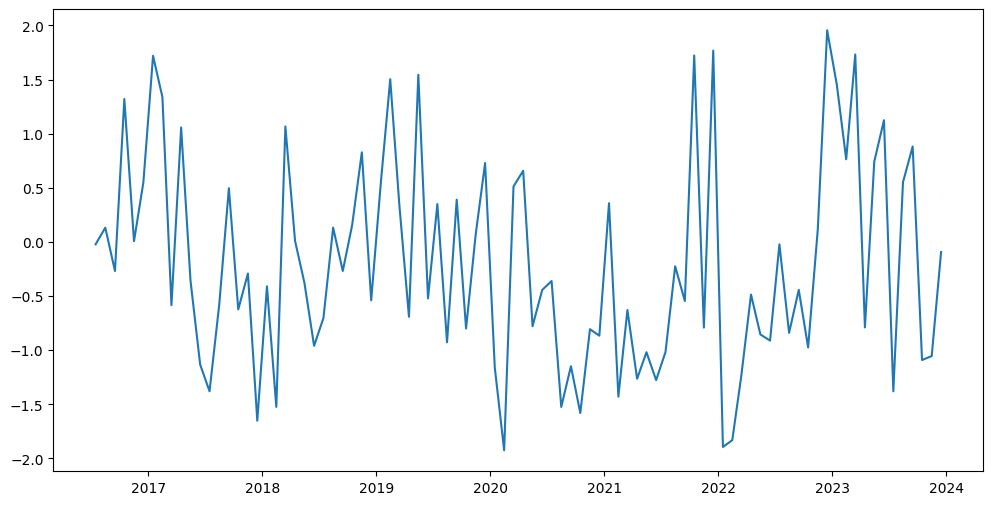

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test_spei1["time"], y_test_spei1, label="Actual SPEI")
plt.plot(test_spei1["time"], y_pred_spei1, label="Predicted SPEI")
plt.xlabel("Time")
plt.ylabel("SPEI-1")
plt.legend()
plt.title("XGBoost Time Series Forecasting (SPEI-1)")
plt.show()

In [ ]:
mae_spei1, mse_spei1, rmse_spei1, r2_spei1 = calculate_metrics(y_test_spei1, y_pred_spei1)
print(f"Mean Absolute Error: {mae_spei1}")
print(f"Mean Squared Error: {mse_spei1}")
print(f"Root Mean Squared Error: {rmse_spei1}")
print(f"R^2 Score: {r2_spei1}")

Mean Absolute Error: 0.38161552580078695
Mean Squared Error: 0.3052802175070466
Root Mean Squared Error: 0.5525216896258884
R^2 Score: 0.6748174023363342


## XGBoost | SPEI-3

### Model Training

In [ ]:
# hyperparameter tuning (grid search)
param_grid = {
    'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000, 2000],
    'max_depth': [3, 5, 7, 10, 15, 20, 22],
    'learning_rate': [0.01, 0.1, 0.15, 0.3, 0.5]
}
tscv = TimeSeriesSplit(n_splits=3)

fine_tuned_xgb_model_spei3 = xgb.XGBRegressor(random_state=42)
grid_search_spei3 = GridSearchCV(estimator=fine_tuned_xgb_model_spei3,
                           param_grid=param_grid,
                           cv=tscv, # cross validation folds
                           verbose=1,
                           scoring='neg_mean_absolute_error')
grid_search_spei3.fit(X_train_spei3, y_train_spei3)

print("Best Parameters:", grid_search_spei3.best_params_)
print("Model details after hyperparameter tuning: ", grid_search_spei3.best_estimator_)

In [ ]:
# model
xgb_model_spei3 = xgb.XGBRegressor(objective="reg:squarederror",
                                   n_estimators=2000,
                                   max_depth=3,
                                   learning_rate=0.1,
                                   early_stopping_rounds=20,
                                   eval_metric="rmse",
                                   random_state=42)

# train
xgb_model_spei3.fit(X_train_spei3, y_train_spei3,
                    eval_set=[(X_val_spei3, y_val_spei3)],
                    verbose=False)

# make predictions
y_pred_spei3 = xgb_model_spei3.predict(X_test_spei3)

### Evaluation

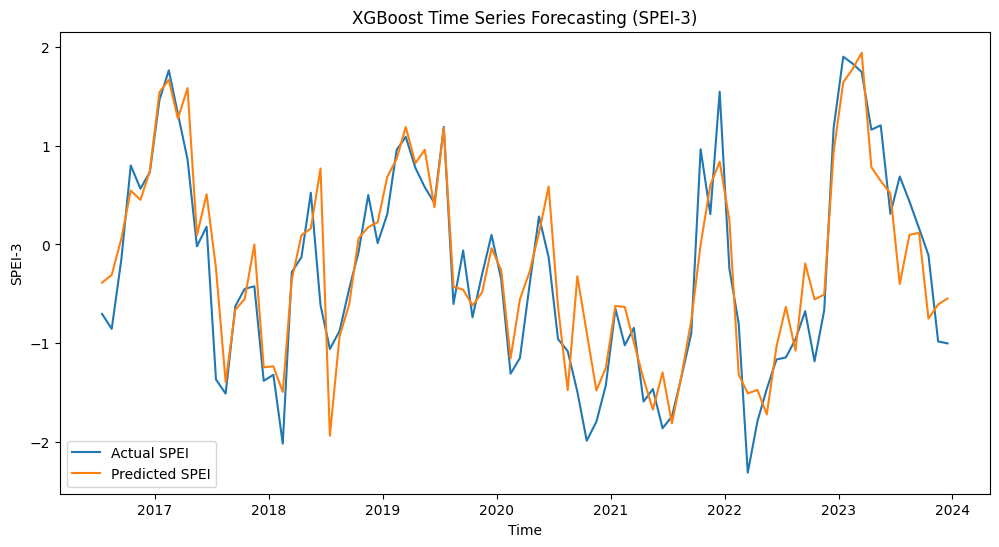

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test_spei3["time"], y_test_spei3, label="Actual SPEI")
plt.plot(test_spei3["time"], y_pred_spei3_after_tuning, label="Predicted SPEI")
plt.xlabel("Time")
plt.ylabel("SPEI-3")
plt.legend()
plt.title("XGBoost Time Series Forecasting (SPEI-3)")
plt.show()

In [ ]:
mae_spei3, mse_spei3, rmse_spei3, r2_spei3 = calculate_metrics(y_test_spei3, y_pred_spei3)
print(f"Mean Absolute Error: {mae_spei3}")
print(f"Mean Squared Error: {mse_spei3}")
print(f"Root Mean Squared Error: {rmse_spei3}")
print(f"R^2 Score: {r2_spei3}")

Mean Absolute Error: 0.35031100323645814
Mean Squared Error: 0.21828509555428846
Root Mean Squared Error: 0.46720990523991296
R^2 Score: 0.7925385911615087


## XGBoost | SPEI-6

### Model Training

In [ ]:
# hyperparameter tuning (grid search)
param_grid = {
    'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000, 2000],
    'max_depth': [3, 5, 7, 10, 15, 20, 22],
    'learning_rate': [0.01, 0.1, 0.15, 0.3, 0.5]
}
tscv = TimeSeriesSplit(n_splits=3)

fine_tuned_xgb_model_spei6 = xgb.XGBRegressor(random_state=42)
grid_search_spei6 = GridSearchCV(estimator=fine_tuned_xgb_model_spei6,
                           param_grid=param_grid,
                           cv=tscv, # cross validation folds
                           verbose=1,
                           scoring='neg_mean_absolute_error')
grid_search_spei6.fit(X_train_spei6, y_train_spei6)

print("Best Parameters:", grid_search_spei6.best_params_)
print("Model details after hyperparameter tuning: ", grid_search_spei3.best_estimator_)

In [ ]:
# model
xgb_model_spei6 = xgb.XGBRegressor(objective="reg:squarederror",
                                   n_estimators=300,
                                   max_depth=3,
                                   learning_rate=0.1,
                                   early_stopping_rounds=20,
                                   eval_metric="rmse",
                                   random_state=42)

# train
xgb_model_spei6.fit(X_train_spei6, y_train_spei6,
                    eval_set=[(X_val_spei6, y_val_spei6)],
                    verbose=False)

# make predictions
y_pred_spei6 = xgb_model_spei6.predict(X_test_spei6)

### Evaluation

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test_spei6["time"], y_test_spei6, label="Actual SPEI")
plt.plot(test_spei6["time"], y_pred_spei6, label="Predicted SPEI")
plt.xlabel("Time")
plt.ylabel("SPEI-6")
plt.legend()
plt.title("XGBoost Time Series Forecasting (SPEI-6)")
plt.show()

In [ ]:
mae, mse, rmse, r2_spei1 = calculate_metrics(y_test_spei6, y_pred_spei6)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2_spei1}")

## XGBoost | SPEI-12

### Model Training

In [ ]:
# hyperparameter tuning (grid search)
param_grid = {
    'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000, 2000],
    'max_depth': [3, 5, 7, 10, 15, 20, 22],
    'learning_rate': [0.01, 0.1, 0.15, 0.3, 0.5]
}
tscv = TimeSeriesSplit(n_splits=3)

fine_tuned_xgb_model_spei12 = xgb.XGBRegressor(random_state=42)
grid_search_spei12 = GridSearchCV(estimator=fine_tuned_xgb_model_spei12,
                           param_grid=param_grid,
                           cv=tscv, # cross validation folds
                           verbose=1,
                           scoring='neg_mean_absolute_error')
grid_search_spei12.fit(X_train_spei12, y_train_spei12)

print("Best Parameters:", grid_search_spei12.best_params_)
print("Model details after hyperparameter tuning: ", grid_search_spei3.best_estimator_)

In [ ]:
# model
xgb_model_spei12 = xgb.XGBRegressor(objective="reg:squarederror",
                                   n_estimators=400,
                                   max_depth=3,
                                   learning_rate=0.01,
                                   early_stopping_rounds=20,
                                   eval_metric="rmse",
                                   random_state=42)

# train
xgb_model_spei12.fit(X_train_spei12, y_train_spei12,
                    eval_set=[(X_val_spei12, y_val_spei12)],
                    verbose=False)

# make predictions
y_pred_spei12 = xgb_model_spei12.predict(X_test_spei12)

### Evaluation

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test_spei12["time"], y_test_spei12, label="Actual SPEI")
plt.plot(test_spei12["time"], y_pred_spei12, label="Predicted SPEI")
plt.xlabel("Time")
plt.ylabel("SPEI-12")
plt.legend()
plt.title("XGBoost Time Series Forecasting (SPEI-12)")
plt.show()

In [ ]:
mae_spei12, mse_spei12, rmse_spei12, r2_spei12 = calculate_metrics(y_test_spei12, y_pred_spei12)
print(f"Mean Absolute Error: {mae_spei12}")
print(f"Mean Squared Error: {mse_spei12}")
print(f"Root Mean Squared Error: {rmse_spei12}")
print(f"R^2 Score: {r2_spei12}")